In [350]:
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import pandas as pd, mysql.connector, nltk
import xgboost, numpy, textblob, string
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers
from nltk.corpus import stopwords
import string
from collections import Counter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Data Preparation

In [4]:
# get the first file which has product titles and brand categoriws
df1 = pd.read_csv('\\Users\\Daniel\\Python\\Data\\Flix_products\\product_title.csv', engine='python')
df1.head(2)

,product_id,title,Categories
0,400002,HP Photosmart eStation Printer,Printers and Multifunction | Inkjet All-in-One...
1,400004,HP LaserJet Pro M1217nfw Multifunction Printer,Printers and Multifunction | Laser Multifuncti...


In [151]:
# load second product file and load only the necessary columns
products_complete = pd.read_csv('\\Users\\Daniel\\Python\\Data\\Flix_products\\products.csv', sep='\t')
products= products_complete[['product_id','product_title','mpn_list','manufacturer_id', 'brand_title',
                            'flix_parent_category', 'flix_subCategory1', 'flix_subCategory2',
                            'benchmark_category', 'benchmark_category2']]
products.head(2)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2
0,3,Crematic Coffee Maker,F8744338,53.0,Groupe SEB,Small Gadgets/Appliances,Drink Makers,Coffee/Espresso,Home Appliances,Drink Makers
1,4,Vitamin Plus 3-Tier Steamer,vc400415,4.0,Tefal,Small Gadgets/Appliances,Cooking,Steamers,Home Appliances,Steamers


In [152]:
# merge the two products file with an inner join to keep only the common products from both
products = pd.merge(products, df1, on='product_id', how='inner')
products.head(2)

,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2,title,Categories
0,881868,HP EliteBook 840 G1 Notebook PC,J8Q77EA,28.0,HP,Computing/Gaming,Laptops/Notebook/Ebook/Ultrabook,Notebooks,Computing,Laptops,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids | Business Laptop PCs | HP...
1,876236,Speedlight SB-N7,FSA90901,1290.0,Nikon,Cameras,Camera Accessories,None,Cameras,Cameras Accessories,Speedlight SB-N7,Speedlights


In [153]:
# check how many products have unassigned categories
products['benchmark_category2'].isna().sum(), products['benchmark_category2'].isna().sum()/len(products.index)

(1680, 0.023105805333590065)

In [154]:
# drop the unassugned category products
products.dropna(subset=['benchmark_category2'], inplace=True)

Text(0.5, 0, '# of products')

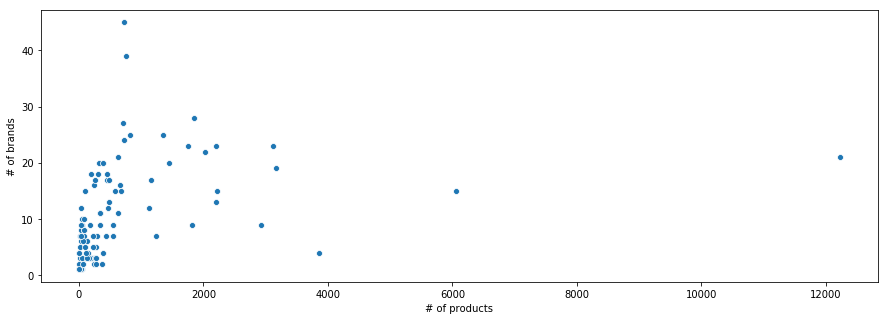

In [10]:
# let's look at the distribution of number of products and brands by product categories
group_products = products.groupby('benchmark_category2')['product_id'].count()
group_brand  = products.groupby('benchmark_category2')['brand_title'].nunique()
plt.figure(figsize=(15,5))
ax = sns.scatterplot(x=group_products, y=group_brand)
ax.set_ylabel('# of brands')
ax.set_xlabel('# of products')

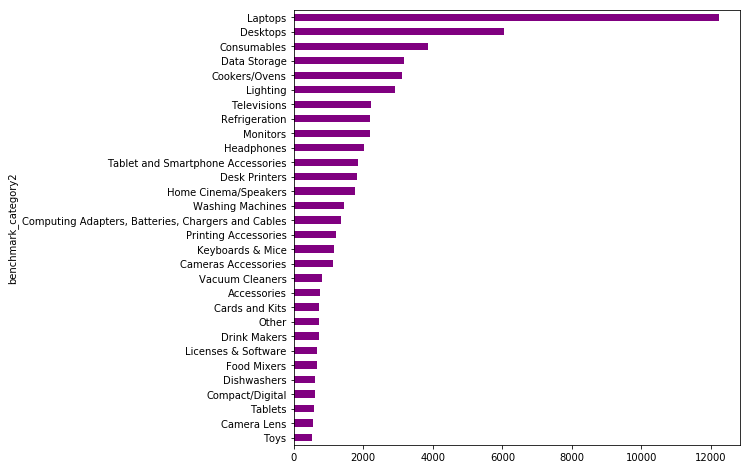

In [160]:
# lets look at the top 30 categories by number of products
products.groupby('benchmark_category2')['product_id'].count().sort_values().tail(30).plot.barh(figsize=(8,8), color='purple')

In [173]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71029 entries, 0 to 71198
Data columns (total 12 columns):
product_id              71029 non-null int64
product_title           70266 non-null object
mpn_list                70388 non-null object
manufacturer_id         71029 non-null float64
brand_title             71028 non-null object
flix_parent_category    71029 non-null object
flix_subCategory1       71029 non-null object
flix_subCategory2       58712 non-null object
benchmark_category      71029 non-null object
benchmark_category2     71029 non-null object
title                   71029 non-null object
Categories              71029 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 7.0+ MB


In [201]:
# lets subset by top 15 categories and use this data for further analysis
topNcats = products.groupby('benchmark_category2')['product_id'].count().nlargest(50).keys()
prod_15cats = products[products['benchmark_category2'].isin(top15cats)].reset_index(drop=True)
prod_15cats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66980 entries, 0 to 66979
Data columns (total 12 columns):
product_id              66980 non-null int64
product_title           66221 non-null object
mpn_list                66381 non-null object
manufacturer_id         66980 non-null float64
brand_title             66980 non-null object
flix_parent_category    66980 non-null object
flix_subCategory1       66980 non-null object
flix_subCategory2       55449 non-null object
benchmark_category      66980 non-null object
benchmark_category2     66980 non-null object
title                   66980 non-null object
Categories              66980 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 6.1+ MB


# 2. Categorisation with product titles and categories

In [202]:
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids | Business Laptop PCs | HP...
1                                          Speedlights
Name: Categories, dtype: object

In [203]:
# Remove the pipes '|' in the Categories
prod_15cats['Categories'] = prod_15cats['Categories'].str.replace('|', '')
prod_15cats['Categories'].head(2)

0    Laptops And Hybrids  Business Laptop PCs  HP E...
1                                          Speedlights
Name: Categories, dtype: object

In [204]:
# lets concatenate the two columns : product titles and categories
prod_15cats['title&cat']=np.nan
for i in range(len(prod_15cats)):
    if pd.isna(prod_15cats.loc[i, 'product_title']):
        prod_15cats.loc[i, 'title&cat'] =  prod_15cats.loc[i, 'title'] + ' ' + prod_15cats.loc[i, 'Categories']
    else:
        prod_15cats.loc[i,'title&cat'] =  prod_15cats.loc[i, 'product_title'] + ' ' + prod_15cats.loc[i, 'Categories']

In [205]:
prod_15cats.to_csv('prod_15cats.csv', sep='\t', encoding='utf-8', index=False)

In [206]:
prod_15cats = pd.read_csv('prod_15cats.csv', sep='\t')

In [162]:
# check for empty strings in the two columns 
#prod_15cats[prod_15cats[['product_title','Categories']].isnull().values.any(1)]

# Bag of Word 

In [335]:
# functions to tokenize the whole doc and form a vocabulary

# clean texts
def tokenize_doc(doc):
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in tokens]
    tokens = [w.lower() for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    return tokens

# load text and add to vocab
def add_to_vocab(column, vocab):
    for i in range(len(column)):
        tokens = tokenize_doc(column[i])
        vocab.update(tokens)  

In [336]:
#create the vocabulary after tokenization of the whole doc
vocab = Counter()
add_to_vocab(prod_15cats['title&cat'], vocab)

In [337]:
# length of the vocab and the most occuring words
len(vocab), print(vocab.most_common(20))
#print(vocab.most_common()[:len(vocab)-100:-1])  # to obtain the lower list

[('hp', 83956), ('pc', 36051), ('notebook', 25169), ('series', 21442), ('pavilion', 12400), ('home', 10349), ('desktop', 10216), ('pcs', 10168), ('workstation', 8245), ('compaq', 7414), ('philips', 7384), ('mobile', 7056), ('consumer', 6471), ('tv', 6311), ('ink', 5969), ('led', 5892), ('elitebook', 5807), ('printer', 5699), ('probook', 5642), ('cartridges', 4790)]


(12169, None)

In [338]:
# remove tokens with just one occurence to reduce the vocab size
tokens = [k for k,c in vocab.items() if c > 1]
print('Vocabulary size: {}'.format( len(tokens)))

Vocabulary size: 7628


In [210]:
# save the vocabulary to a file
def save_vocab(lines, filename):
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w', encoding="utf-8")
    file.write(data)
    file.close()
    
# save the vocabulary
save_vocab(tokens, 'vocab.txt')

In [211]:
# function to tokenize each row
def tokenize_row(column, vocab):
    tokenz = []
    for i in range(len(column)):
        tokens = tokenize_doc(column[i])
        tokens = [w for w in tokens if w in vocab]
        tokenz.append(tokens)
    return tokenz

In [328]:
# tokenize each row
prod_15cats['tokens'] = tokenize_row(prod_15cats['title&cat'], vocab)
prod_15cats['tokens'].head()

0    [hp, elitebook, 840, g1, notebook, pc, laptops...
1                      [speedlight, sbn7, speedlights]
2    [electrolux, efc60465ox, chimney, design, hood...
3    [electrolux, efc90468ox, chimney, design, hood...
4        [oven, evy9841aox, electrolux, nonstar, oven]
Name: tokens, dtype: object

In [331]:
# convert tokens in the list to texts to make it vectorizing freindly
prod_15cats['tokens']=[" ".join(tokens) for tokens in prod_15cats['tokens'].values]
prod_15cats['tokens'].head()

0    hp elitebook 840 g1 notebook pc laptops hybrid...
1                          speedlight sbn7 speedlights
2    electrolux efc60465ox chimney design hood 60 c...
3    electrolux efc90468ox chimney design hood 90 c...
4              oven evy9841aox electrolux nonstar oven
Name: tokens, dtype: object

In [307]:
# function to plot bar-chart of groupby agg counts
def bar_plot(df,group_column, agg):
    df.groupby(group_column)[agg].count().sort_values(ascending=False).plot.bar(figsize=(12,6), color='purple')

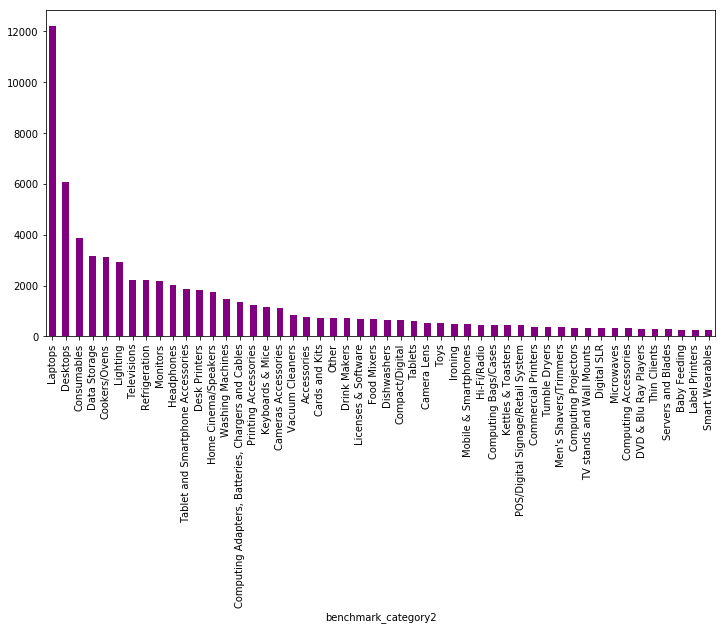

In [309]:
# plot the count of products by categories
bar_plot(prod_15cats, 'benchmark_category2' ,'product_id')

# Train and Test data split with stratified sampling

In [217]:
# create train and test set with stratified sampling
model_data = prod_15cats.copy()
y = model_data.pop('benchmark_category2')
x = model_data['tokens']
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.30, random_state=42, stratify=y)

# TF-IDF Vectors as features

In [218]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

In [317]:
# reverse transformation of LabelEncoder
#encoder.inverse_transform(y_test)
#print(list(encoder.classes_))

In [224]:
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{2,}', stop_words='english', max_features=7000)
tfidf_vect.fit(prod_15cats['tokens'].map(str))
x_train_tfidf =  tfidf_vect.transform(x_train)
x_test_tfidf =  tfidf_vect.transform(x_test)
len(tfidf_vect.vocabulary_), x_train_tfidf.shape

(7000, (46886, 7000))

In [225]:
#x_train_tfidf[1,:150].toarray()

# Prediction Models

In [226]:
# Naive Bayes on Word Level TF-IDF Vectors
NB_clf = naive_bayes.MultinomialNB().fit(x_train_tfidf, y_train)
predicted = NB_clf.predict(x_test_tfidf)
np.mean(predicted == y_test)

0.8844431173484623

In [227]:
LR_clf = linear_model.LogisticRegression().fit(x_train_tfidf, y_train)
predicted = LR_clf.predict(x_test_tfidf)
np.mean(predicted == y_test)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.9320195083109386

In [237]:
RF_clf = ensemble.RandomForestClassifier().fit(x_train_tfidf, y_train)
predicted = RF_clf.predict(x_test_tfidf)
np.mean(predicted == y_test)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9361003284562556

In [232]:
len(predicted), len(y_test)

(20094, 20094)

In [250]:
encoder.inverse_transform(predicted)

array(['Ironing', 'Refrigeration', 'Laptops', ..., 'Keyboards & Mice',
       'Monitors', 'Desktops'], dtype=object)

In [313]:
# subset the training data rows from the main dataframe
train_data = prod_15cats.iloc[list(x_test.index.values),:]
# add the predicted columns to the train_data
train_data['predicted'] = encoder.inverse_transform(predicted)

In [323]:
# the wrong predictions
#train_data[train_data['benchmark_category2'] != train_data['predicted']].head(5)

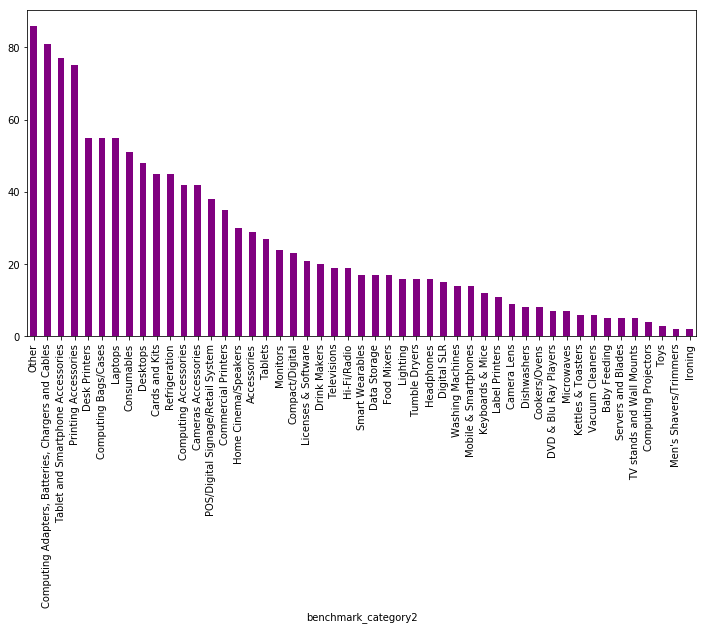

In [315]:
# plot a count of the wrong categories
bar_plot(wrong_predictions, 'benchmark_category2' ,'product_id')

# One hot-encoding - Count Vectors as features

In [332]:
prod_15cats.head(2)

,product_id,product_title,mpn_list,manufacturer_id,brand_title,flix_parent_category,flix_subCategory1,flix_subCategory2,benchmark_category,benchmark_category2,title,Categories,title&cat,tokens
0,881868,HP EliteBook 840 G1 Notebook PC,J8Q77EA,28.0,HP,Computing/Gaming,Laptops/Notebook/Ebook/Ultrabook,Notebooks,Computing,Laptops,HP EliteBook 840 G1 Notebook PC,Laptops And Hybrids Business Laptop PCs HP E...,HP EliteBook 840 G1 Notebook PC Laptops And Hy...,hp elitebook 840 g1 notebook pc laptops hybrid...
1,876236,Speedlight SB-N7,FSA90901,1290.0,Nikon,Cameras,Camera Accessories,None,Cameras,Cameras Accessories,Speedlight SB-N7,Speedlights,Speedlight SB-N7 Speedlights,speedlight sbn7 speedlights


In [341]:
# create a count vectorizer object 
count_vect = CountVectorizer(analyzer='word', token_pattern=r'\w{2,}', stop_words='english')
count_vect.fit(prod_15cats['tokens'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='\\w{2,}', tokenizer=None,
        vocabulary=None)

In [345]:
len(count_vect.vocabulary_)

50699

In [346]:
# transform the training and validation data using count vectorizer object
x_train_CV =  count_vect.transform(x_train)
x_test_CV =  count_vect.transform(x_test)

In [347]:
# Naive Bayes on Word Level TF-IDF Vectors
NB_clf = naive_bayes.MultinomialNB().fit(x_train_CV, y_train)
predicted = NB_clf.predict(x_test_CV)
np.mean(predicted == y_test)

0.8967353438837464

In [349]:
RF_clf = ensemble.RandomForestClassifier().fit(x_train_CV, y_train)
predicted = RF_clf.predict(x_test_CV)
np.mean(predicted == y_test)

C:\Users\Daniel\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9363989250522544

In [379]:
# function to train a model and return accuracy, average precision and recall
def train_model(classifier, train_data, test_data):
    classifier.fit(train_data, y_train)
    predictions = classifier.predict(test_data)
    print('Accuracy: {}'.format(metrics.accuracy_score(predictions, y_test)))
    #return np.mean(predictions == y_test)
    cm = confusion_matrix(y_test, predictions)
    precision = np.diag(cm) / np.sum(cm, axis = 0)
    recall = np.diag(cm) / np.sum(cm, axis = 1)  
    #F1 = 2*np.average(recall)*np.average(precision)/(np.average(recall) + np.average(precision))
    print('Average Precision: {}'.format(np.average(precision)))
    print('Average Recall: {}'.format(np.average(recall)))   

In [380]:
train_model(naive_bayes.MultinomialNB(), x_train_CV, x_test_CV )

Accuracy: 0.8967353438837464
Average Precision: 0.8946480801862797
Average Recall: 0.7859809086488719


In [365]:
# confusion matrix, precison and recall
cm = confusion_matrix(y_test, predicted)
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)
F1 = 2*np.average(recall)*np.average(precision)/(np.average(recall) + np.average(precision))